# Setup

## Create Filesystem
This notebook is primarily meant to be executed in Colab as a computational backend. If you want to run on your own hardware with data, you need to set `data_dir` and `ALLOW_IO`

This notebook viewable directly on Colab from [https://colab.research.google.com/github/rcharan/phutball/blob/rl/pytorch-implementation/model-training.ipynb](https://colab.research.google.com/github/rcharan/phutball/blob/rl/pytorch-implementation/model-training.ipynb) (it is a mirror of github). But if it has moved branches or you are looking at a past commit, look at the [Google instructions](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb) on where to find this file.

The workflow is:
 - Data stored in (my personal/private) Google Drive
 - Utilities/library files (for importing) on github, edited on local hardware and pushed to github.
 - Notebook hosted on github, edited both in Colab or locally (depending on the relative value of having a GPU attached versus being able to use regular Jupyter keyboard shortcuts/a superior interface)

In [1]:
# Attempt Colab setup if on Colab
try:
  import google.colab
except:
  ALLOW_IO = False
else:
  # Mount Google Drive at data_dir
  #  (for data)
  from google.colab import drive
  from os.path import join
  ROOT = '/content/drive'
  DATA = 'My Drive/phutball'
  drive.mount(ROOT)
  ALLOW_IO = True
  data_dir = join(ROOT, DATA)
  !mkdir "{data_dir}"     # in case we haven't created it already   

  # Pull in code from github
  %cd /content
  github_repo = 'https://github.com/rcharan/phutball'
  !git clone -b rl {github_repo}
  %cd /content/phutball
  
  # Point python to code base
  import sys
  sys.path.append('/content/phutball/pytorch-implementation')

  # Updater for library functions changed on local hardware and pushed to github
  #  (circuitous, I know)
  def update_repo():
    !git pull

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/My Drive/phutball’: File exists
/content
Cloning into 'phutball'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 1470 (delta 53), reused 53 (delta 28), pack-reused 1382
Receiving objects: 100% (1470/1470), 6.36 MiB | 4.50 MiB/s, done.
Resolving deltas: 100% (881/881), done.
/content/phutball


## Imports

In [0]:
%%capture

%load_ext autoreload
%autoreload 2

import os
import gc
import numpy as np

# Codebase
from lib.model_v1          import TDConway
from lib.off_policy        import EpsilonGreedy
from lib.optim             import AlternatingTDLambda

from lib.training          import training_loop

from lib.utilities         import config, lfilter
from lib.testing_utilities import create_state, visualize_state, boards
from lib.timer             import Timer

from lib.moves             import END_LOC, COL, CHAIN
from lib.move_selection    import get_next_move_training


# Graphics for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
plt.ioff()

# PyTorch
import torch

## Device Management Utilities
Setup for GPU, CPU, or (not working well/fully implemented) TPU

In [3]:
use_tpu = False

if use_tpu:
  # Install PyTorch/XLA
  VERSION = "nightly" #["20200220","nightly", "xrt==1.15.0"]
  !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
  !python pytorch-xla-env-setup.py --version $VERSION
  import torch_xla
  import torch_xla.core.xla_model as xm
  
  # Set the device
  device = xm.xla_device()
  
  # Memory inspection
  def print_memory_usage():
    print('TPU memory inspection not implemented')
  def print_max_memory_usage():
    print('TPU memory inspection not implemented')
  def garbage_collect():
    gc.collect() # No TPU specific implementation yet
    
elif torch.cuda.is_available():
  # Set the device
  device = torch.device('cuda')
  
  # Echo GPU info
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  print(gpu_info)
  
  # Memory inspection and management
  from lib.memory import (
    print_memory_usage_cuda     as print_memory_usage,
    print_max_memory_usage_cuda as print_max_memory_usage,
    garbage_collect_cuda        as garbage_collect
  )

else:
  # Set the device to CPU
  device = torch.device('cpu')
  
  # Echo RAM info
  from psutil import virtual_memory
  from lib.memory import format_bytes
  ram = virtual_memory().total
  print(format_bytes(ram), 'available memory on CPU-based runtime')
  
  # Memory inspection and management
  from lib.memory import (
    print_memory_usage, 
    print_max_memory_usage,
    garbage_collect
  )

Thu May 14 22:01:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Execution

## Instantiate

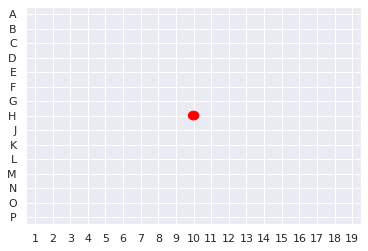

In [4]:
epsilon_greedy = EpsilonGreedy(0.1)

model = TDConway(config).to(device)
optimizer = AlternatingTDLambda(model.parameters(), 0.01, 0.9)

initial_state = create_state('H10').to(device)
visualize_state(initial_state)

## Profile

In [5]:
# Blazing fast on a P100! # Okay on a T4
%timeit get_next_move_training(initial_state, model, device);

The slowest run took 6.74 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 58.1 ms per loop


In [6]:
# Decently fast. 84ms/move on P100.
training_loop(model, optimizer, 1, device, off_policy = epsilon_greedy)


Playing game 1 of 1:
71/71 [==============================] - 9s 125ms/step


## Run!

In [0]:
training_loop(model, optimizer, 200, device, off_policy = epsilon_greedy)


Playing game 1 of 200:
107/107 [==============================] - 13s 122ms/step

Playing game 2 of 200:
102/102 [==============================] - 12s 120ms/step

Playing game 3 of 200:
60/60 [==============================] - 8s 131ms/step

Playing game 4 of 200:
108/108 [==============================] - 13s 121ms/step

Playing game 5 of 200:
61/61 [==============================] - 8s 130ms/step

Playing game 6 of 200:
88/88 [==============================] - 11s 131ms/step

Playing game 7 of 200:
79/79 [==============================] - 9s 117ms/step

Playing game 8 of 200:
139/139 [==============================] - 16s 117ms/step

Playing game 9 of 200:
55/55 [==============================] - 7s 133ms/step

Playing game 10 of 200:
83/83 [==============================] - 11s 127ms/step

Playing game 11 of 200:
70/70 [==============================] - 9s 122ms/step

Playing game 12 of 200:
73/73 [==============================] - 9s 125ms/step

Playing game 13 of 200:
95/95 [===

In [0]:
def save(fname, model, optimizer):
  state_dict = {
      'model' : model.state_dict(),
      'optim' : optimizer.state_dict()
  }
  torch.save(state_dict, f'{data_dir}/{fname}.pt')

hello?

In [0]:
version = '0.1.2'
game_num = 400
save(f'v{version}-{game_num}', model, optimizer)